<a href="https://colab.research.google.com/github/manannarang/MeshRCNN/blob/main/Demo_MeshRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@ Credit to Meher Shashwat meher.shashwat@students.iiit.ac.in and Alberto Tono alberto.tono@cd.institute

# Requirements and Setup
It will take a while to install all the dependencies and expect around 20min to run this demo on this Google Colab

In [4]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
%env FORCE_CUDA=1
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install pyyaml==5.1 pycocotools>=2.0.1
!pip install -U fvcore
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

env: FORCE_CUDA=1
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 24kB/s 
     |████████████████████████████████| 6.6MB 67.8MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201020-cp36-none-any.whl size=44210 sha256=01d2e68d63a57a7a03f28453076b7f143ddabc2921ae9eac4f2864f537aa9476
  Stored in directory: /root/.cache/pip/wheels/71/6c/b5/198f89a5c5f127327730248cc623e5a307ad11ed287c3fe391
Successfully built fvcore
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 377kB/s 
  Cloning https://github.com/facebookresearch/pytorch3d.git to /

## Imports and checking installation parameters(python 3.6.9, cuda 10.1)

In [5]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available(),torch.cuda.device_count())
!gcc --version
!python --version
!nvcc --version
!nvidia-smi
!python -m detectron2.utils.collect_env

1.5.0+cu101 True 1
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Python 3.6.9
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Mon Oct 26 12:11:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==============

## Installing meshrcnn
It will create a folder structure on your left in which you can navigate


In [6]:
!git clone https://github.com/facebookresearch/meshrcnn.git
!cd meshrcnn && pip install -e .

Cloning into 'meshrcnn'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 235 (delta 2), reused 9 (delta 2), pack-reused 213
Receiving objects: 100% (235/235), 132.63 KiB | 270.00 KiB/s, done.
Resolving deltas: 100% (85/85), done.
Obtaining file:///content/meshrcnn
  Running setup.py develop for meshrcnn


# Loading Pix3D Dataset
Also this import will take a while since it is loading the entire dataset 3.5GB


In [7]:
# pix3d data
!./meshrcnn/datasets/pix3d/download_pix3d.sh

--2020-10-26 12:11:52--  http://pix3d.csail.mit.edu/data/pix3d.zip
Resolving pix3d.csail.mit.edu (pix3d.csail.mit.edu)... 128.52.128.175
Connecting to pix3d.csail.mit.edu (pix3d.csail.mit.edu)|128.52.128.175|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783261880 (3.5G) [application/zip]
Saving to: ‘pix3d.zip’

pix3d.zip           100%[===================>]   3.52G  13.3MB/s    in 4m 39s  

2020-10-26 12:16:31 (12.9 MB/s) - ‘pix3d.zip’ saved [3783261880/3783261880]

--2020-10-26 12:18:00--  https://dl.fbaipublicfiles.com/meshrcnn/pix3d/pix3d_s1_train.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781155 (4.6M) [text/plain]
Saving to: ‘pix3d_s1_train.json’

pix3d_s1_train.json 100%[===================>]   4.56M  4.77MB/s    in 1.0s    

2020-10-26

In [10]:
from google.colab import files
uploaded = files.upload()  # import a sofa from your computer and name it test.jpg

Saving test.jpg to test (1).jpg


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Demo (Inference)

In [11]:
# Running Demo on random image of the pix3d dataset, change according to your need (change 'test.jpg' to your file name)
# Be sure to upload the file on the correct folder

!python ./meshrcnn/demo/demo.py --config-file ./meshrcnn/configs/pix3d/meshrcnn_R50_FPN.yaml \
--input /content/test.jpg --output output_demo --onlyhighest MODEL.WEIGHTS meshrcnn://meshrcnn_R50.pth

[10/26 12:36:33 demo]: Arguments: Namespace(config_file='./meshrcnn/configs/pix3d/meshrcnn_R50_FPN.yaml', focal_length=20.0, input='/content/test.jpg', onlyhighest=True, opts=['MODEL.WEIGHTS', 'meshrcnn://meshrcnn_R50.pth'], output='output_demo')
meshrcnn_R50.pth: 487MB [00:29, 16.6MB/s]               
[10/26 12:37:17 demo]: Predictions saved in output_demo/test


# Visualize the Picture Uploaded and the Segmentation Mask 

In [12]:
filename = 'test.jpg' #check the name is the same as the file you uploaded
maskname = '0_mask_chair_0.999.png' # Make sure to change the file name with the appropriate mask change 'test/0_mask_sofa_1.000.png'

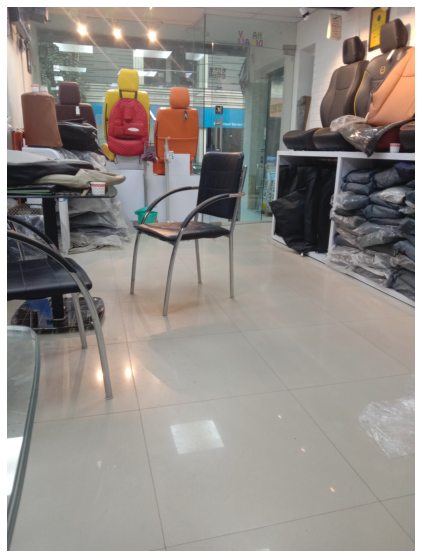

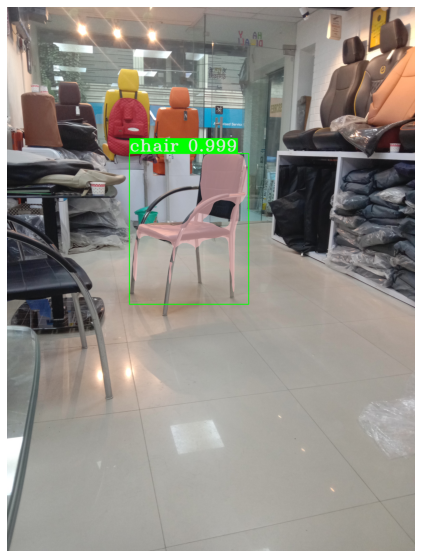

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

img = plt.imread("/content/" + filename) 
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
img = plt.imread("/content/output_demo/test/" + maskname)  
plt.imshow(img)
plt.axis('off')
plt.show()

# Download the .obj file

In [ ]:
name = 'chair' # change file name accordingly

In [14]:
from google.colab import files
files.download('/content/output_demo/test/0_mesh_chair_0.999.obj')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>